## Importing necessary packages

In [31]:
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 469.7 kB/s eta 0:00:00a 0:00:01
DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [62]:
import pandas as pd
from itables import show
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from geopy.distance import great_circle
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

## Loading dataset and EDA

In [3]:
data = pd.read_csv('data/AB_NYC_2019.csv')

In [4]:
data.shape

(48895, 16)

The dataset has 48895 rows and 16 columns

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

### Data description
This dataset has 48,895 rows and 16 columns.
The columns include:
- **id** ID for each property
- **name** Description of the property as provided by the host
- **host_id** ID for each host
- **host_name** Name of the host
- **neighbourhood_group** Name of the neighbourhood group
- **neighbourhood** Name of the neighbourhood
- **latitude** Location Latitude of the property
- **longitude** Location Longitude of the property
- **room_type** Type of Room
- **price** Price of the Room
- **minimum_nights** Minimum number of nights the room is available for booking
- **number_of_reviews** Number of reviews the property has received from past guests
- **last_review** Date of Last Review
- **reviews_per_month** Average Number of reviews received per month
- **calculated_host_listings_count** Total number of properties available for Rent from this host
- **availability_365** Number of Days out of the last 365 days that the property has been available for rent

In [6]:
show(data)

**Drop the features that will not be useful for this analysis**  

In [7]:
data.drop(['host_name', 'last_review'], axis=1, inplace=True)

### Dealing with missing values the missing records

In [8]:
data.isnull().sum()

id                                    0
name                                 16
host_id                               0
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

**Visualising missing values**

<Axes: >

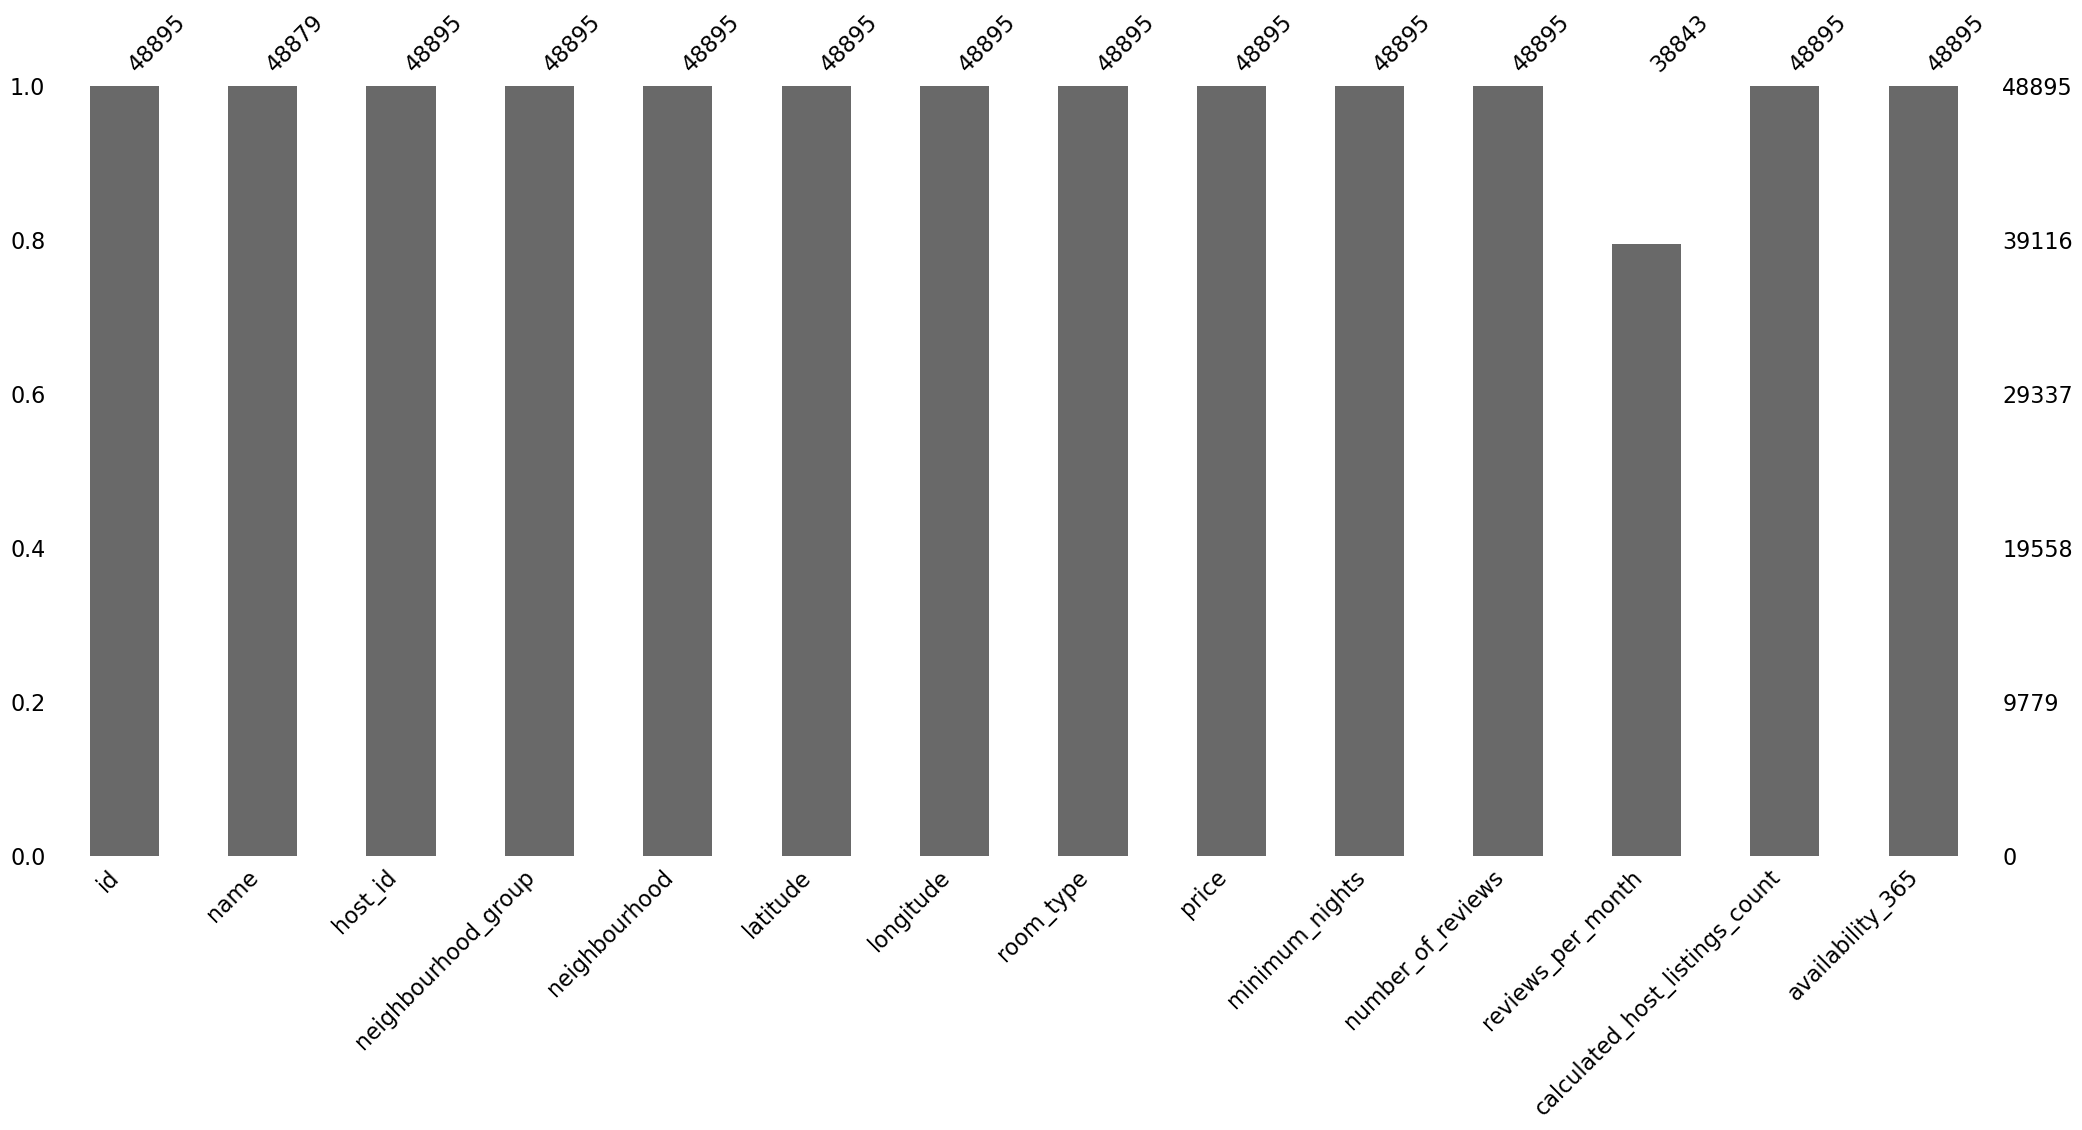

In [9]:
msno.bar(data)

In [10]:
filtered_df = data[data['reviews_per_month'].isnull()][['number_of_reviews', 'reviews_per_month']]
show(filtered_df)

**Observation on missing records**  
Whenever we have 0 number of reviews is where we have NaN for review_per_month, so this missing records for reviews_per_month could be missing because there is actually no reviews for these listings. We can replace NaNs with 0.

In [11]:
data.fillna({'reviews_per_month':0}, inplace=True)
data.reviews_per_month.isnull().sum()

0

In [12]:
data.fillna({'name':'None'}, inplace=True)
data.name.isnull().sum()

0

### Summary Statistics

In [13]:
data.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.090910,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.597283,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [14]:
features = data[['price', 'minimum_nights', 'number_of_reviews', 
            'reviews_per_month', 'calculated_host_listings_count', 'availability_365']]
show(features)

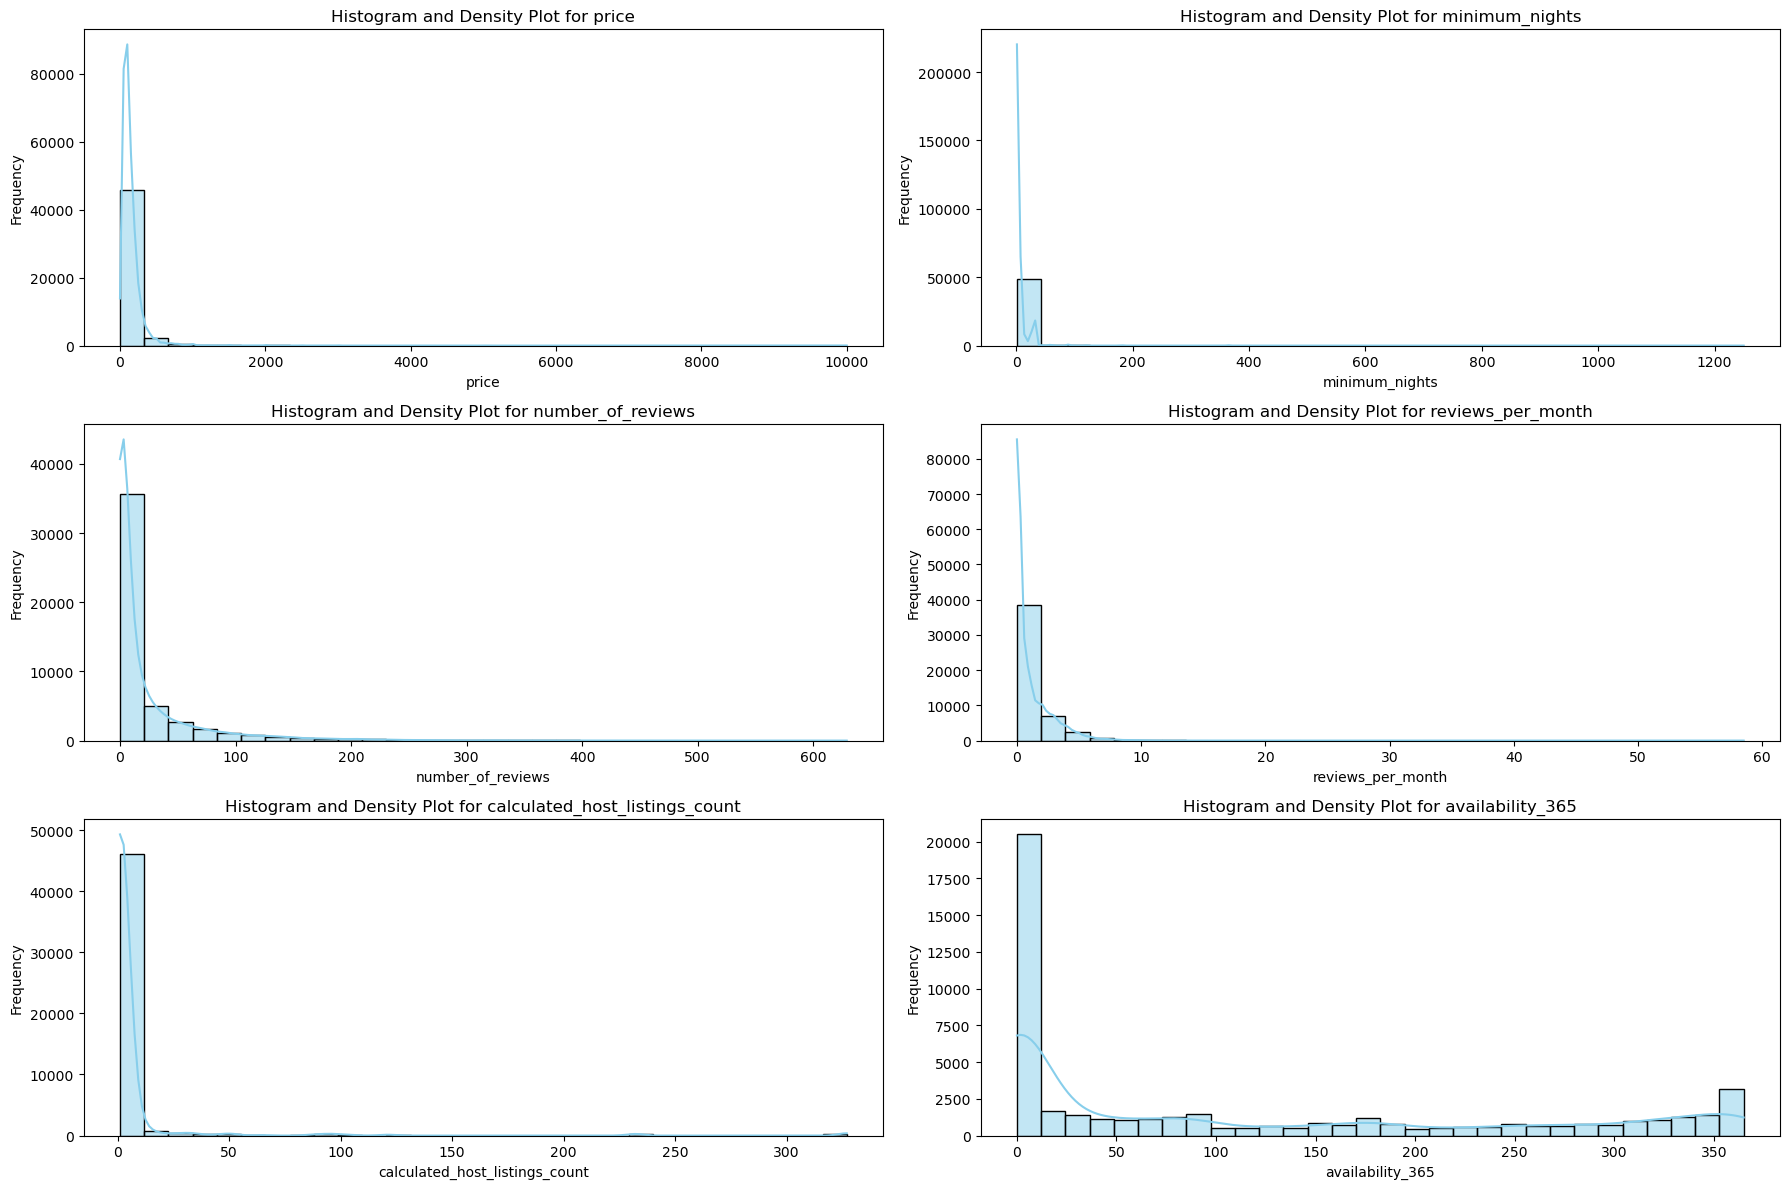

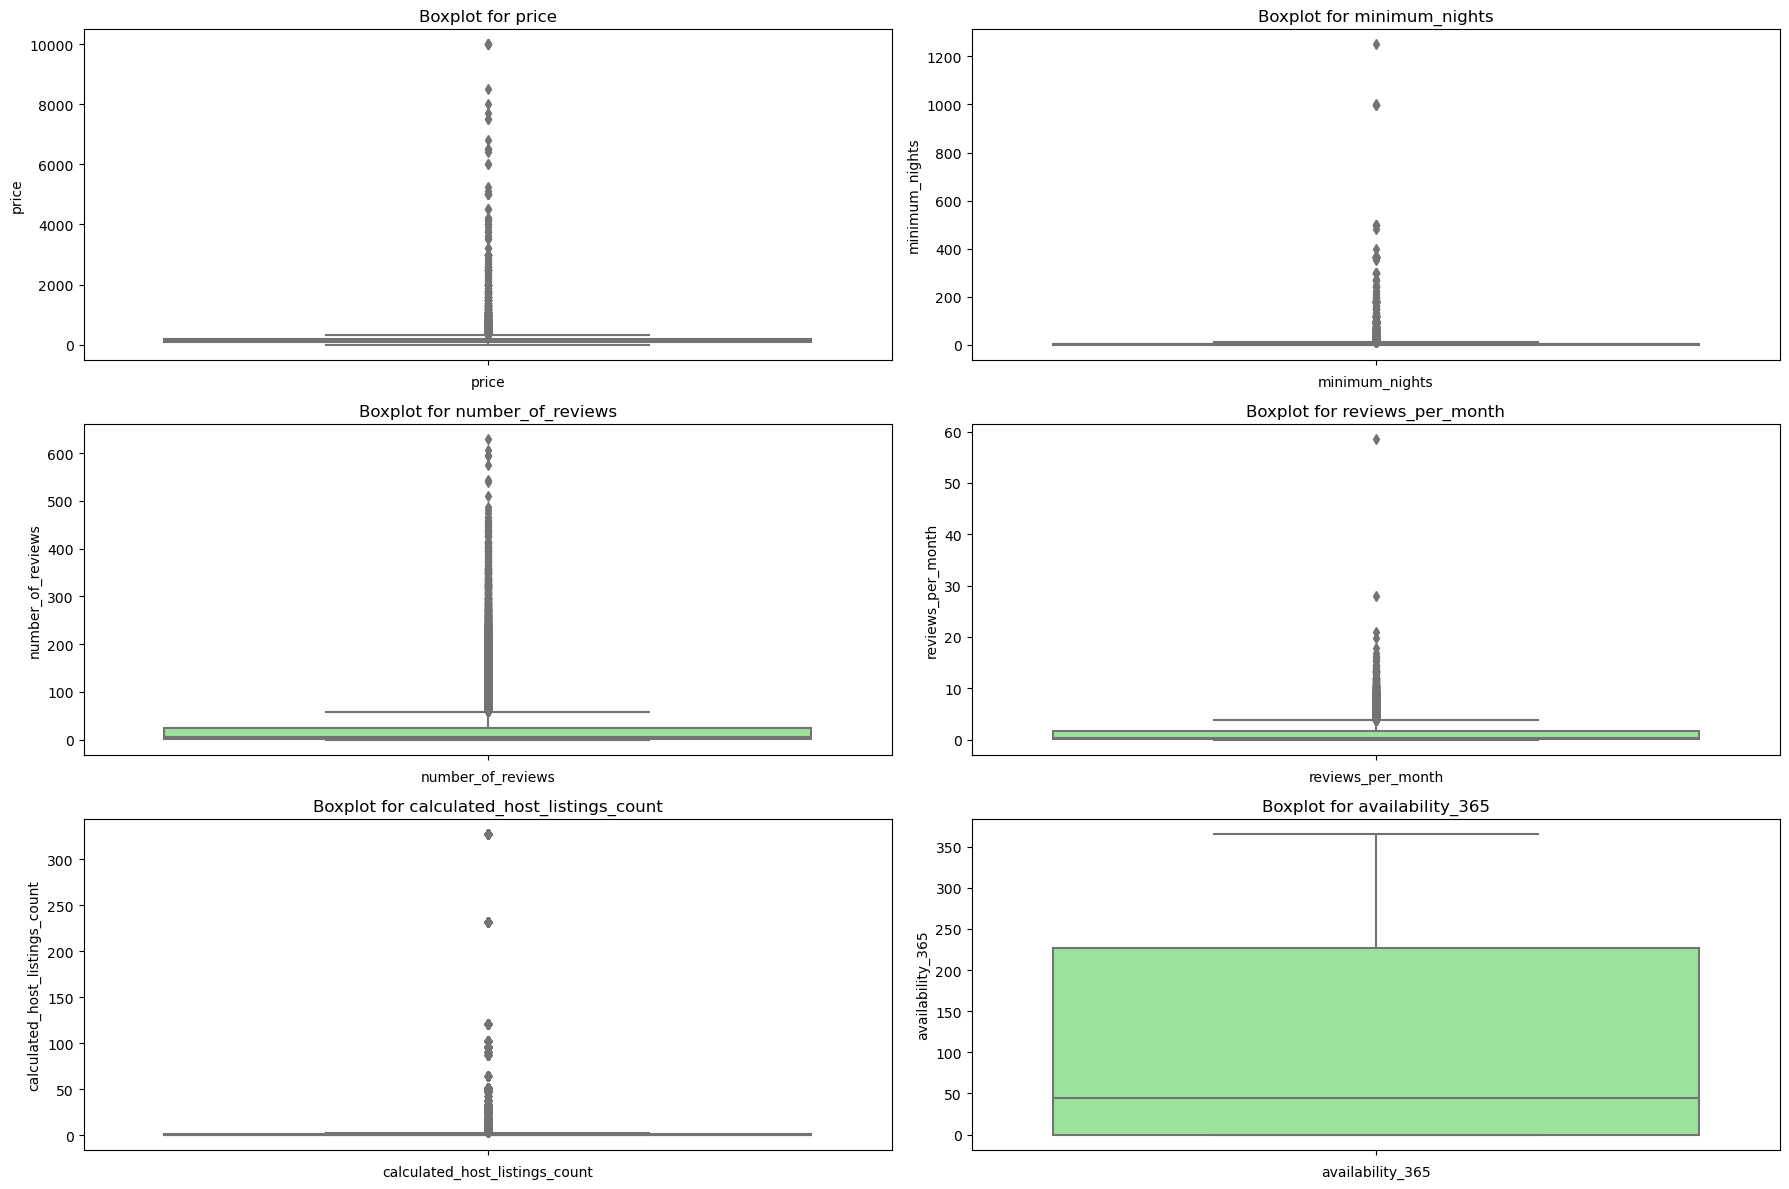

In [15]:
# Set up the matplotlib figure
plt.figure(figsize=(18, 12))

for i, feature in enumerate(features, 1):
    # Create a subplot for each feature
    plt.subplot(3, 2, i)
    
    # Generate both histogram and density plot for each feature
    sns.histplot(data[feature], kde=True, bins=30, color='skyblue')
    plt.title(f'Histogram and Density Plot for {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    
plt.tight_layout()
plt.show()

# Now, plotting boxplots for each feature to investigate outliers
plt.figure(figsize=(18, 12))

for i, feature in enumerate(features, 1):
    # Create a subplot for each feature
    plt.subplot(3, 2, i)
    
    # Generate boxplot for each feature
    sns.boxplot(y=data[feature], color='lightgreen')
    plt.title(f'Boxplot for {feature}')
    plt.xlabel(feature)
    
plt.tight_layout()
plt.show()


**Interpretation of the skewness analysis**  
- Price: The histogram for the price feature shows a highly **right-skewed** distribution, indicating that most listings are priced at the lower end, with a few listings having very high prices. The peak of the density plot is close to zero, and there are extreme values stretching towards the higher end of the price range. The boxplot for price indicates that the median price is relatively low compared to the maximum value, which is consistent with the skew seen in the histogram. There are many extreme values or outliers, as shown by the points above the upper whisker of the boxplot. This suggests that while most listings are at a lower price, there are some listings with a very high price.
- Minimum Nights: Similar to the price, the minimum_nights feature is also highly **right-skewed**. The vast majority of listings require only a few nights' minimum stay, with a long tail of listings requiring an unusually high minimum number of nights. The boxplot for minimum_nights shows that the median is low and that there are numerous outliers above the upper whisker. These outliers represent listings that have a very high minimum night requirement.
- Number of Reviews: The distribution of the number_of_reviews is **right-skewed** as well, with most listings having a low number of reviews and only a few listings with a very high number of reviews. The peak is close to zero, suggesting many listings have few or no reviews. The boxplot indicates that the median value is low compared to the maximum, showing that many listings have a few reviews, but there are listings with a very high number of reviews (outliers).
- Reviews Per Month: This feature is also **right-skewed**. Most listings have a low number of reviews per month, indicating sporadic reviews, while a few listings have a higher frequency of reviews per month. Similar to the number_of_reviews, the reviews_per_month feature has a low median value with a considerable number of outliers that indicate some listings receive many reviews in a month, much higher than the average.
- Calculated Host Listings Count: The histogram and density plot for calculated_host_listings_count show a very strong **right skew**. Most hosts have a low number of listings, with a steep drop-off as the number of listings increases. The peak is near zero, which suggests that single listings are very common among hosts. The median value of host listings count is close to zero, suggesting that most hosts manage a small number of listings. There are some outliers indicating that a few hosts have a significantly larger number of listings.
- Availability 365: The histogram for availability_365 appears to have a **bimodal distribution** with one peak near zero and another peak at the maximum value of 365 days. This indicates that there is a significant number of listings either rarely available or available throughout the entire year. The boxplot shows a wide interquartile range (IQR), with the top of the box at or near the maximum of 365 days. This could suggest that many listings are available for most or all of the year. There are no apparent outliers, indicating a more uniform distribution of data across the available days.
  >> Conclusion:
  >> From this it is apparent there are so many outliers in this dataset, we can look at how the distribution changes in different neighbourhoods

### Distribution in regards to different neighbourhoods

In [16]:
neighbourhood_group_counts = data['neighbourhood_group'].value_counts()
neighbourhood_group_counts_percents = neighbourhood_group_counts
print(neighbourhood_group_counts)

neighbourhood_group
Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: count, dtype: int64


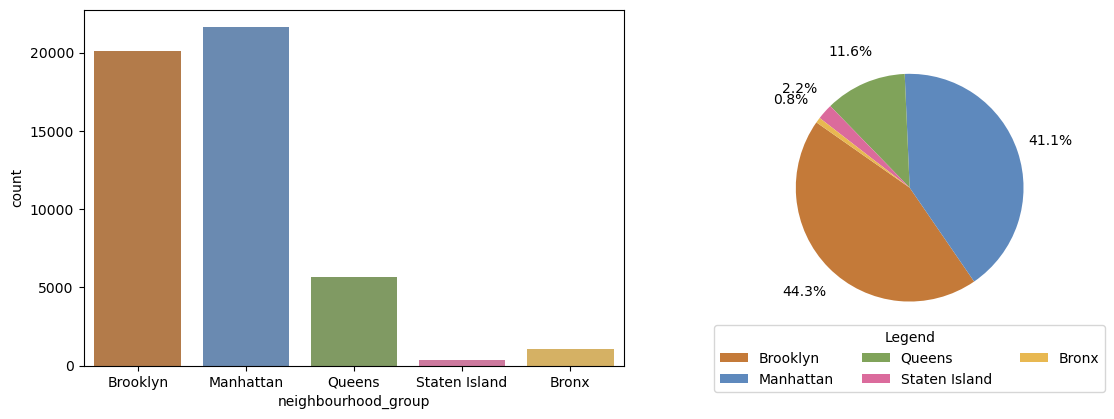

In [17]:
neighbourhood_groups_colours = ['#c47a39', '#5e89bd', '#80a35a', '#db6b9c', '#e8b851']
plt.figure(figsize=(12, 8))
plt.subplots_adjust(wspace=0.2)

plt.subplot(2, 2, 1)
sns.countplot(data=data, x='neighbourhood_group', palette=neighbourhood_groups_colours)
plt.subplot(2, 2, 2)
plt.pie(data['neighbourhood_group'].value_counts(),
        autopct='%1.1f%%',
        colors=neighbourhood_groups_colours,
        pctdistance=1.3,
        radius=0.8,
        startangle=145)
plt.legend(title='Legend',
           loc='center',
           ncol=3,
           bbox_to_anchor=(0.5, 0.02),
           labels=data['neighbourhood_group'].unique())


plt.tight_layout()
plt.show()

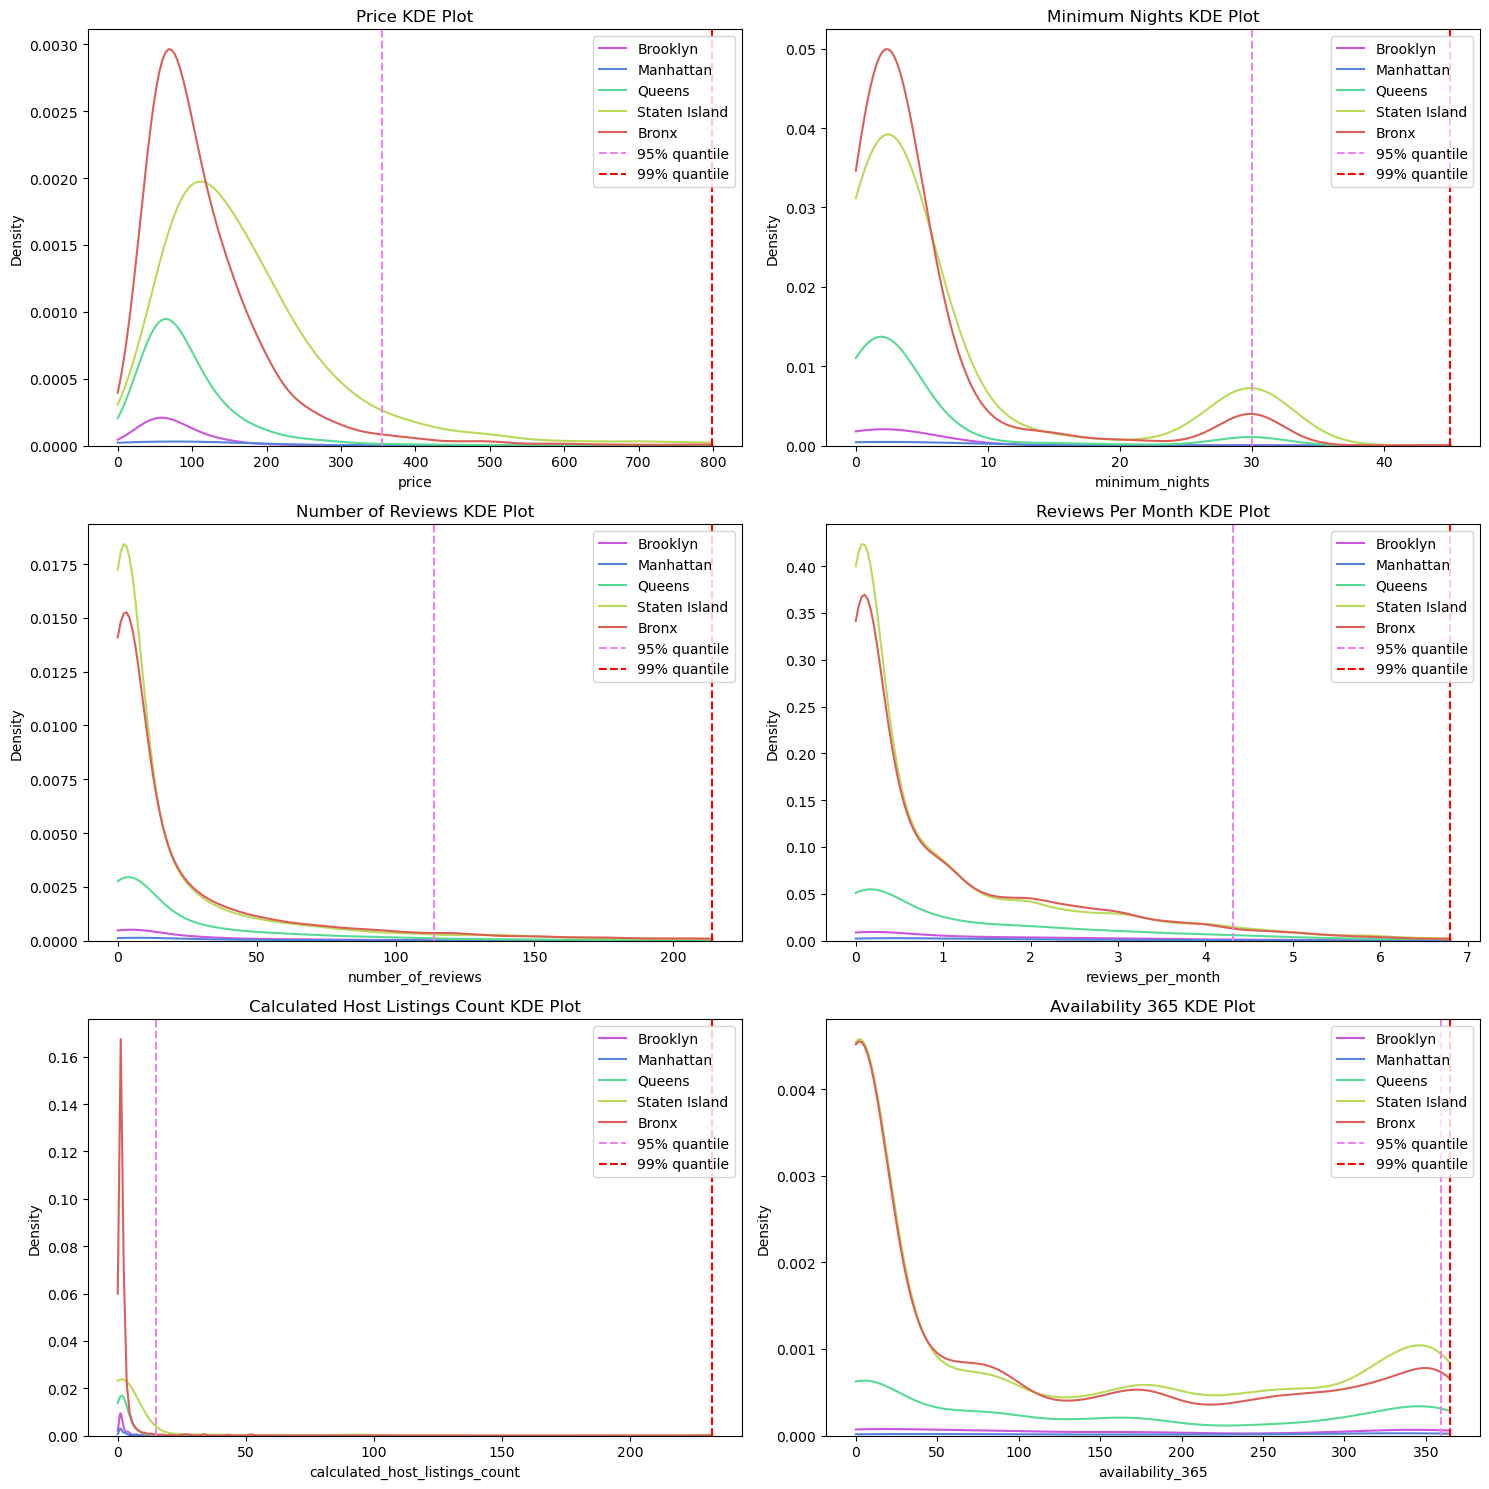

In [18]:
# Define your color palette
groups_colours = sns.color_palette("hls", 5) # Assuming there are 5 neighborhood groups

# Your custom legend list
dis_legend = ['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx', '95% quantile', '99% quantile']

plt.figure(figsize=(15, 15))  # Adjust the size of the overall figure

# Plot KDE for 'price'
plt.subplot(3, 2, 1)
sns.kdeplot(data=data, x='price', hue='neighbourhood_group', clip=(0, data['price'].quantile(0.99)), palette=groups_colours)
plt.axvline(data['price'].quantile(0.95), label='95% quantile', c='violet', linestyle='--')
plt.axvline(data['price'].quantile(0.99), label='99% quantile', c='red', linestyle='--')
plt.title('Price KDE Plot')
plt.legend(dis_legend, loc='upper right')

# Plot KDE for 'minimum_nights'
plt.subplot(3, 2, 2)
sns.kdeplot(data=data, x='minimum_nights', hue='neighbourhood_group', clip=(0, data['minimum_nights'].quantile(0.99)), palette=groups_colours)
plt.axvline(data['minimum_nights'].quantile(0.95), label='95% quantile', c='violet', linestyle='--')
plt.axvline(data['minimum_nights'].quantile(0.99), label='99% quantile', c='red', linestyle='--')
plt.title('Minimum Nights KDE Plot')
plt.legend(dis_legend, loc='upper right')

# Plot KDE for 'number_of_reviews'
plt.subplot(3, 2, 3)
sns.kdeplot(data=data, x='number_of_reviews', hue='neighbourhood_group', clip=(0, data['number_of_reviews'].quantile(0.99)), palette=groups_colours)
plt.axvline(data['number_of_reviews'].quantile(0.95), label='95% quantile', c='violet', linestyle='--')
plt.axvline(data['number_of_reviews'].quantile(0.99), label='99% quantile', c='red', linestyle='--')
plt.title('Number of Reviews KDE Plot')
plt.legend(dis_legend, loc='upper right')

# Plot KDE for 'reviews_per_month'
plt.subplot(3, 2, 4)
sns.kdeplot(data=data, x='reviews_per_month', hue='neighbourhood_group', clip=(0, data['reviews_per_month'].quantile(0.99)), palette=groups_colours)
plt.axvline(data['reviews_per_month'].quantile(0.95), label='95% quantile', c='violet', linestyle='--')
plt.axvline(data['reviews_per_month'].quantile(0.99), label='99% quantile', c='red', linestyle='--')
plt.title('Reviews Per Month KDE Plot')
plt.legend(dis_legend, loc='upper right')

# Plot KDE for 'calculated_host_listings_count'
plt.subplot(3, 2, 5)
sns.kdeplot(data=data, x='calculated_host_listings_count', hue='neighbourhood_group', clip=(0, data['calculated_host_listings_count'].quantile(0.99)), palette=groups_colours)
plt.axvline(data['calculated_host_listings_count'].quantile(0.95), label='95% quantile', c='violet', linestyle='--')
plt.axvline(data['calculated_host_listings_count'].quantile(0.99), label='99% quantile', c='red', linestyle='--')
plt.title('Calculated Host Listings Count KDE Plot')
plt.legend(dis_legend, loc='upper right')

# Plot KDE for 'availability_365'
plt.subplot(3, 2, 6)
sns.kdeplot(data=data, x='availability_365', hue='neighbourhood_group', clip=(0, data['availability_365'].quantile(0.99)), palette=groups_colours)
plt.axvline(data['availability_365'].quantile(0.95), label='95% quantile', c='violet', linestyle='--')
plt.axvline(data['availability_365'].quantile(0.99), label='99% quantile', c='red', linestyle='--')
plt.title('Availability 365 KDE Plot')
plt.legend(dis_legend, loc='upper right')

plt.tight_layout()
plt.show()


In [19]:
data.groupby('neighbourhood_group')['price'].mean().sort_values()

neighbourhood_group
Bronx             87.496792
Queens            99.517649
Staten Island    114.812332
Brooklyn         124.383207
Manhattan        196.875814
Name: price, dtype: float64

In [20]:
mean_values_sorted = {}

for feature in features:
    mean_values_sorted[feature] = data.groupby('neighbourhood_group')[feature].mean().sort_values()
for feature, mean_values in mean_values_sorted.items():
    print(f"Mean values for {feature} sorted by neighbourhood_group:")
    print(mean_values)
    print() 

Mean values for price sorted by neighbourhood_group:
neighbourhood_group
Bronx             87.496792
Queens            99.517649
Staten Island    114.812332
Brooklyn         124.383207
Manhattan        196.875814
Name: price, dtype: float64

Mean values for minimum_nights sorted by neighbourhood_group:
neighbourhood_group
Bronx            4.560953
Staten Island    4.831099
Queens           5.181433
Brooklyn         6.056556
Manhattan        8.579151
Name: minimum_nights, dtype: float64

Mean values for number_of_reviews sorted by neighbourhood_group:
neighbourhood_group
Manhattan        20.985596
Brooklyn         24.202845
Bronx            26.004583
Queens           27.700318
Staten Island    30.941019
Name: number_of_reviews, dtype: float64

Mean values for reviews_per_month sorted by neighbourhood_group:
neighbourhood_group
Manhattan        0.976782
Brooklyn         1.049790
Bronx            1.475655
Queens           1.567076
Staten Island    1.576381
Name: reviews_per_month, dtype: 

In [21]:
data.columns

Index(['id', 'name', 'host_id', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

**Interpretation of the distribution of the features across different neighbourhood groups**  
- Price: The peak of the Manhattan curve is at a higher price point compared to the other neighborhood groups, suggesting that Manhattan has higher listing prices on average.
Brooklyn follows Manhattan but with a slightly lower peak price, while Queens, Staten Island, and Bronx have their peaks at even lower prices, indicating more affordable listing options on average. The 95% quantile line (magenta dotted line) shows the price below which 95% of the listings are found. It is much higher in Manhattan, indicating that prices are skewed towards the higher end in this neighborhood group.The 99% quantile line (red dashed line) is indicating even more extreme price points that only the top 1% of listings reach. This line is considerably further out for Manhattan, suggesting a significant presence of luxury listings.
- Minimum Nights: The distribution for each neighborhood group appears to have a similar shape, but the curves for Manhattan and Brooklyn are slightly shifted to the right compared to Queens, Staten Island, and the Bronx. This could suggest a tendency for listings in Manhattan and Brooklyn to require slightly longer minimum stays.
  
>> In both plots(Price and Minimum Nights), the presence of long tails to the right suggests that there are listings with significantly higher prices and longer minimum nights than the majority, especially in Manhattan. This is typical of accommodation data, where most listings are moderately priced and targeted toward short stays, with a few high-priced, luxury listings or listings that require long stays, potentially skewing the average upwards.

- Number of Reviews: Most listings across all neighborhood  groups have a low number of reviews, as indicated by the peaks near zero. The distributions for all neighborhood groups are right-skewed, meaning that there are a few listings with a very high number of reviews, but they are rare. The curve for Manhattan is slightly higher in the lower review count area, which could indicate that listings in Manhattan, on average, have more reviews compared to other neighborhoods. However, it also tapers off more quickly than Brooklyn, suggesting fewer Manhattan listings with a very high number of reviews.
- Reviews per Month: The plot for reviews_per_month is quite steep for all neighborhood  groups, indicating that most listings have few reviews per month, with the frequency rapidly declining as the number of reviews per month increases. Manhattan stands out with a higher peak at the low end, which may imply that listings in Manhattan get reviewed slightly more frequently per month than in other areas. This could be due to higher turnover or popularity.
- Calculated Host Listings Count:  This plot suggests that most hosts across all neighborhood  groups have a low number of listings, as indicated by the peaks very close to zero.
The distributions are heavily right-skewed, showing that a small number of hosts have many listings, with the vast majority having fewer listings. The 95% quantile line (magenta dotted line) is very close to the left, indicating that 95% of all hosts have a count of listings that falls below this line. The proximity of this line to the y-axis suggests that the majority of hosts have very few listings. The 99% quantile line (red dashed line) is farther to the right, indicating that only 1% of hosts have a listing count higher than this, which is representative of the long tail in the distribution.
- Availability 365:All neighborhood groups show a double-peaked distribution, suggesting two groups of listings: those that are rarely available and those that are frequently available throughout the year.The peaks for all neighborhood groups appear around 0 and just below 365, indicating a substantial number of listings are either available all year round or hardly available at all. The 95% and 99% quantile lines are less pronounced here compared to the calculated_host_listings_count plot, likely because the availability_365 values are more evenly spread out.

>> Overall, the density plots suggest that **Manhattan** has higher-priced listings with potentially longer stays and more frequent reviews, likely due to higher demand and turnover. Most hosts have few properties, but there are notable exceptions with large portfolios, and the availability varies with many listings open all year or very infrequently. 


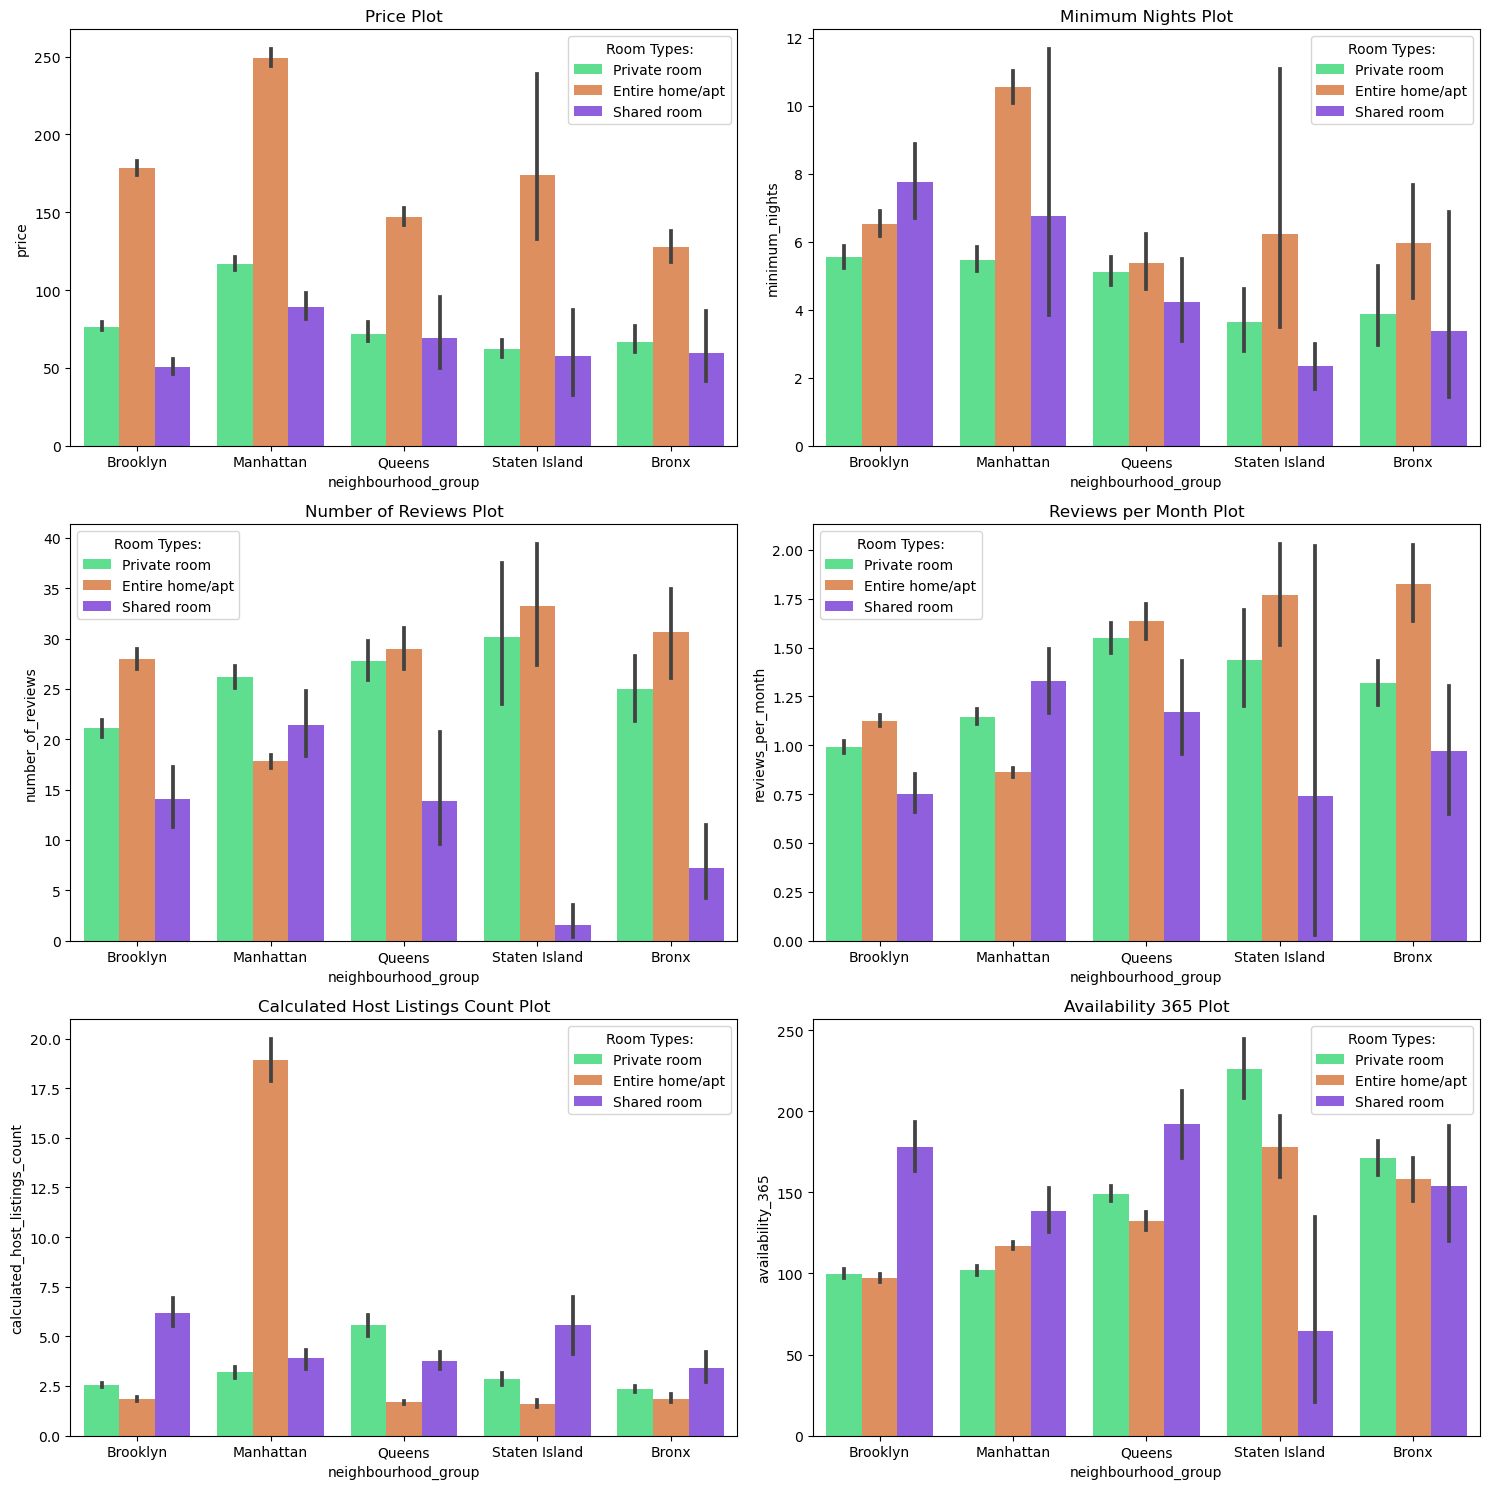

In [22]:
plt.figure(figsize=(15, 15))  

room_colours = ['#4af38a', '#f38a4a', '#8a4af3']

# Plot 'price'
plt.subplot(3, 2, 1)
sns.barplot(data=data,
            x='neighbourhood_group',
            y='price',
            hue='room_type',
            palette=room_colours)
plt.title('Price Plot')
plt.legend(title='Room Types:')

# Plot 'minimum nights'
plt.subplot(3, 2, 2)
sns.barplot(data=data,
            x='neighbourhood_group',
            y='minimum_nights',
            hue='room_type',
            palette=room_colours)
plt.title('Minimum Nights Plot')
plt.legend(title='Room Types:')

# Plot 'number of reviews'
plt.subplot(3, 2, 3)
sns.barplot(data=data,
            x='neighbourhood_group',
            y='number_of_reviews',
            hue='room_type',
            palette=room_colours)
plt.title('Number of Reviews Plot')
plt.legend(title='Room Types:')

# Plot 'reviews per month'
plt.subplot(3, 2, 4)
sns.barplot(data=data,
            x='neighbourhood_group',
            y='reviews_per_month',
            hue='room_type',
            palette=room_colours)
plt.title('Reviews per Month Plot')
plt.legend(title='Room Types:')

# Plot 'calculated host listings count'
plt.subplot(3, 2, 5)
sns.barplot(data=data,
            x='neighbourhood_group',
            y='calculated_host_listings_count',
            hue='room_type',
            palette=room_colours)
plt.title('Calculated Host Listings Count Plot')
plt.legend(title='Room Types:')

# Plot 'availability 365'
plt.subplot(3, 2, 6)
sns.barplot(data=data,
            x='neighbourhood_group',
            y='availability_365',
            hue='room_type',
            palette=room_colours)
plt.title('Availability 365 Plot')
plt.legend(title='Room Types:')

plt.tight_layout()
plt.show()

**Interpretation of the results for the**
- Price: In every neighborhood group, entire homes/apartments are the most expensive on average, followed by private rooms, and then shared rooms. Manhattan has the highest average prices for all types of accommodations, significantly higher than the other neighborhoods, especially for entire homes/apartments. The error bars (which represent the confidence interval or standard deviation) indicate variability in the prices, with Manhattan showing the greatest variability, suggesting a wide range of prices within the category.
- Minimum Nights: Entire homes/apartments generally require longer minimum stays compared to private rooms and shared rooms. Manhattan and Queens show the highest average minimum night requirements for entire homes/apartments, indicating that these accommodations may be targeted towards longer stays. The error bars here also show significant variability, especially for entire homes/apartments in Manhattan and shared rooms in Queens, suggesting less uniformity in the minimum stay requirements within these categories.
- Number of reviews: The entire homes/apartments generally have the highest number of reviews, followed by private rooms, and then shared rooms, indicating that entire homes/apartments tend to be reviewed more often than other types of listings.Queens shows the highest average number of reviews for entire homes/apartments, while Brooklyn leads for private rooms. Shared rooms have a relatively lower number of reviews across all neighborhoods.Error bars indicate the variability in the number of reviews, with entire homes/apartments in Queens showing considerable variability.
- Reviews per Month: Private rooms seem to lead in the average number of reviews per month in most neighborhoods, with entire homes/apartments following closely. Shared rooms tend to have fewer reviews per month.Staten Island shows a notable average reviews per month for private rooms, which could indicate a high turnover or high guest interest in that room type within this neighborhood.There is significant variability in reviews per month across all neighborhoods and room types, as suggested by the length of the error bars. Staten Island, in particular, shows large variability for private rooms, suggesting some private rooms there are extremely active, whereas others much less so.
- Calculated Host Listings Count: Manhattan has the highest average number of listings per host, especially for entire homes/apartments, suggesting that hosts in Manhattan are more likely to manage multiple properties. The other neighborhoods generally show lower averages, with hosts managing fewer properties, indicating that hosting in these areas might be less concentrated. Error bars signify the spread of the data around the mean, with Manhattan showing significant variability, which means there's a mix of hosts with varying numbers of listings.
- Avaialability 365: Entire homes/apartments in Staten Island show a particularly high average availability, which could indicate that these properties are more frequently vacant or dedicated full-time to short-term rentals.Manhattan and Queens also show relatively high availability for entire homes/apartments, suggesting a similar trend. Private rooms and shared rooms have lower availability on average, which might reflect that they are more likely to be lived in by the hosts or are more frequently booked. The variability in availability, as shown by the error bars, is quite significant in some cases, especially for entire homes/apartments in Staten Island and shared rooms in Queens.

  >> Manhattan is characterised by higher prices, longer minimum stays, a higher number of reviews, and more listings managed per host, which aligns with its status as a prime, high-demand location. It suggests a professionalised and possibly more commercialised short-term rental market.

  >> Staten Island shows a higher availability for entire homes/apartments and a high frequency of reviews for private rooms, indicating distinct usage patterns that might reflect its residential nature and emerging popularity in the short-term rental market.

  >> Brooklyn and Queens present themselves as mid-range markets with more moderate prices, minimum stays, and reviews, which might appeal to a broader range of travelers seeking both short-term and longer-term accommodations.

  >> The Bronx seems to be similar to Brooklyn and Queens but with fewer reviews, indicating it is less frequented by travelers or is an emerging market in the accommodation-sharing space.

***Overall, these findings paint a picture of a diverse accommodation-sharing ecosystem in New York City, with Manhattan as the hub of high-end, frequently reviewed, and professionally managed listings; Staten Island as a potentially seasonal or specialised market with availability patterns that suggest a mix of short-term and potentially leisure-oriented rentals; and Brooklyn, Queens, and the Bronx serving as accessible options that cater to a variety of accommodation needs.***


## Map of neighbourhood group

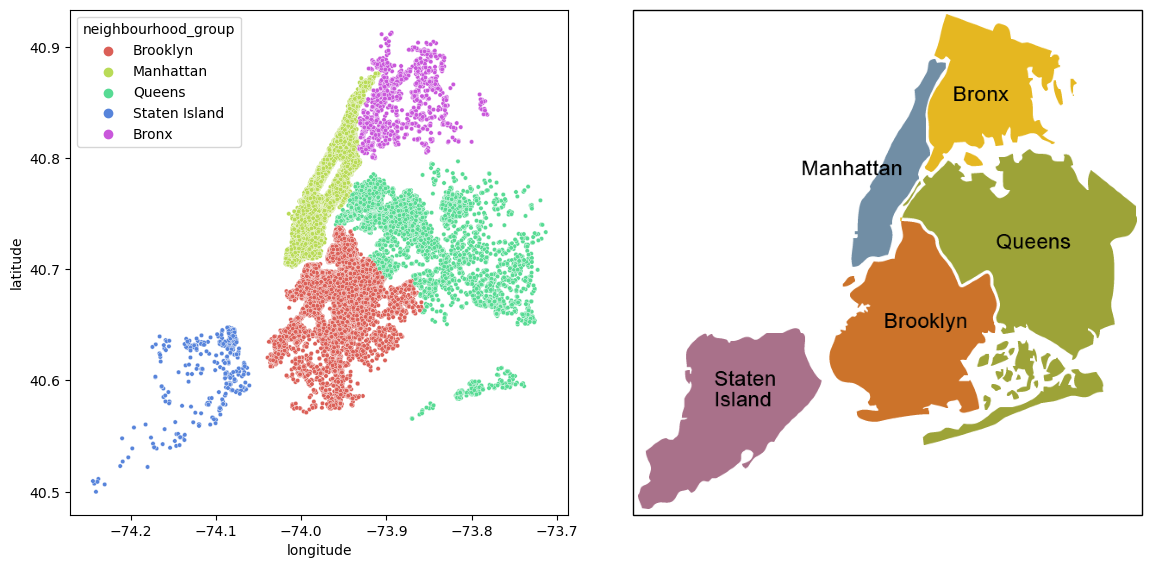

In [23]:
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot(data=data,
                x='longitude',
                y='latitude',
                hue='neighbourhood_group',
                ax=ax_1,
                palette=groups_colours,
                s=10)

img_path = 'https://usastudy.narod.ru/images/raion.gif'
img = plt.imread(urllib.request.urlopen(img_path), format='gif')
img_box = OffsetImage(img, zoom=0.62)
ab = AnnotationBbox(img_box, (0.5, 0.5))
ax_2.add_artist(ab)
ax_2.axis('off')

plt.tight_layout()
plt.show()

**There is dense clustering in Manhattan and Brooklyn, indicating a higher number of listings in this areas**

In [24]:
data.columns

Index(['id', 'name', 'host_id', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

### Wordcloud

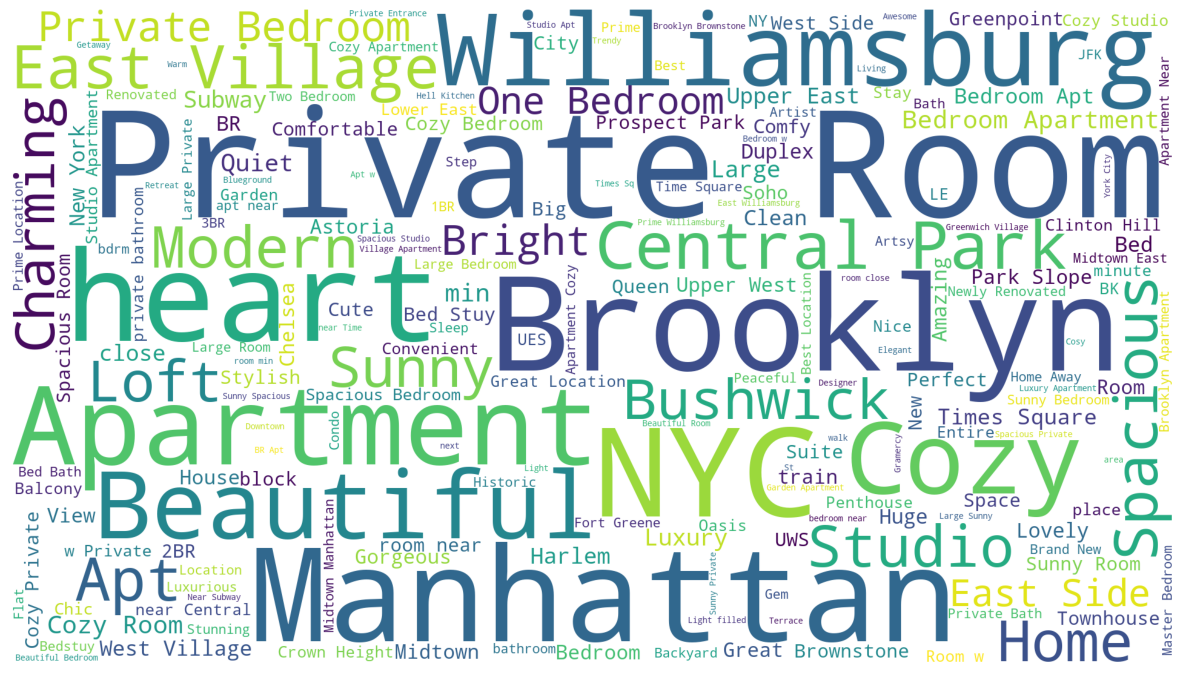

In [35]:
plt.subplots(figsize=(15,15))
wordcloud = WordCloud(
                          background_color='white',
                          width=1920,
                          height=1080
                         ).generate(" ".join(data.name))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('ListingsName.png')
plt.show()

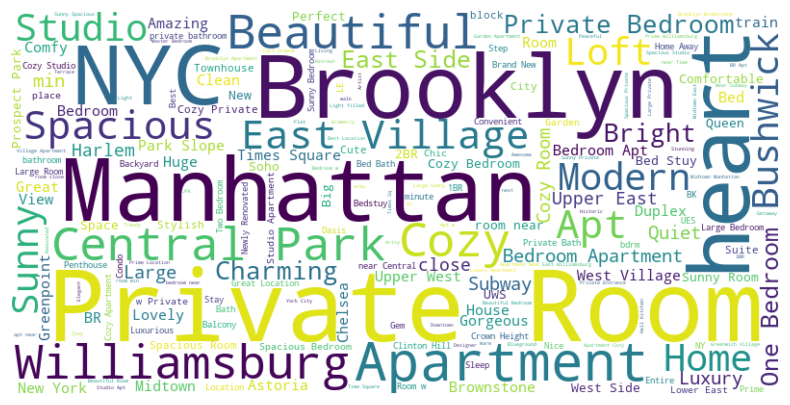

In [43]:
text = ' '.join(review for review in data['name'])
wordcloud = WordCloud(background_color='white',
                      max_words=200,
                      width=800, height=400).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Clustering Analysis

In [55]:
attractions_data = pd.read_csv('data/New York Attractions.csv')
show(attractions_data)

In [65]:
attractions_data.columns

Index(['Attraction', 'Latitude', 'Longitude'], dtype='object')

In [56]:
# Define a function to calculate the distance to the nearest attraction for each listing
def calculate_nearest_attraction_distance(listing_lat, listing_lon, attractions):
    distances = attractions.apply(
        lambda row: great_circle((listing_lat, listing_lon), (row['latitude'], row['longitude'])).meters,
        axis=1
    )
    return distances.min()

In [57]:
distance_data = data
show(distance_data)

In [79]:
def calculate_distance_to_attraction(row, attraction):
    return great_circle(
        (row['latitude'], row['longitude']),
        (attraction['Latitude'], attraction['Longitude'])
    ).meters
            

for _, attraction in attractions_data.iterrows():
    column_name = f"distance_to_{attraction['Attraction'].replace(' ', '_')}"
    data[column_name] = data.apply(calculate_distance_to_attraction, axis=1, attraction=attraction)


In [80]:
show(distance_data)

In [ ]:
# Define a function to calculate distances to the attractions
def calculate_distances(row, attractions):
    return [great_circle((row['latitude'], row['longitude']), (attr['Latitude'], attr['Longitude'])).meters for _, attr in attractions.iterrows()]

# Apply the function to each listing in the Airbnb dataset and create new columns for each attraction's distance
for i, attraction in attractions_data.iterrows():
    airbnb_data[f'distance_to_attraction_{i}'] = airbnb_data.apply(lambda row: great_circle((row['latitude'], row['longitude']), (attraction['Latitude'], attraction['Longitude'])).meters, axis=1)

In [25]:
# clustering_features = ['latitude', 'longitude', 'price', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
# data_clustering = data[clustering_features]
# data_clustering.info()

In [26]:
# # Normalize the data
# scaler = StandardScaler()
# data_normalized = scaler.fit_transform(data_clustering)

In [27]:
# # Using the Elbow Method to find the optimal number of clusters
# wcss = []
# for i in range(1, 11):
#     kmeans = KMeans(n_clusters=i, init='k-means++', n_jobs=-1, random_state=42)
#     kmeans.fit(data_normalized)
#     wcss.append(kmeans.inertia_)

# # Plotting the results onto a line graph to observe 'The Elbow'
# plt.figure(figsize=(10, 5))
# plt.plot(range(1, 11), wcss)
# plt.title('Elbow Method')
# plt.xlabel('Number of clusters')
# plt.ylabel('WCSS')
# plt.show()

In [28]:
# import folium
# from folium.plugins import HeatMap

# # Assuming 'data' is a DataFrame that contains 'latitude' and 'longitude' columns

# # Create a base map
# map = folium.Map(location=[data['latitude'].mean(), data['longitude'].mean()], zoom_start=12)

# # Plot each listing as a point on the map
# for idx, row in data.iterrows():
#     folium.CircleMarker(
#         location=[row['latitude'], row['longitude']],
#         radius=3,
#         fill=True,
#         color='blue',
#         fill_color='blue'
#     ).add_to(map)

# # Alternatively, create a heat map of listings
# heat_data = [[row['latitude'], row['longitude']] for idx, row in data.iterrows()]
# HeatMap(heat_data).add_to(map)

# # Display the map
# map
